Group Project 1

Part 1: 

The below code outlines our data collection process. To collect our data, we used the free Event Registry API to collect article summaries on different topics from many different news sources. We chose to collect articles on Tesla because it is one of the largest companies in the world, and is very frequently discussed in the news. We believe this would result in a lot of discussion about it online, which would give us a lot of data to use. 

First, we created and EventRegistry object, which allowed us to use our API key, and a QueryEvents object to collect articles on Tesla. We were only able to get the 50 most recent articles due to limitations from the free API. Following that, we extracted the article summaries from our articles and formatted them as a list of strings to pass through our preprocessing stage. We believe this is a good process; we were able to get good, short article summaries from the websites. The only limitation is the limit of 50 articles for our query; this does not give us nearly enough data to do a very comprehensive analysis on the current sentiment of Tesla. More data from a paid API would allow us to better understand the current sentiment on Tesla. 

In [1]:
# Use API to get news sources

import eventregistry
import requests
from eventregistry import * #used from NewsApi github page, the readme file

api = "ad26c405-f5ee-4187-b1b7-797a193d73f7"

er = EventRegistry(apiKey = api)
q = QueryEvents(keywords = "Tesla")
q.setRequestedResult(RequestEventsInfo(sortBy = "date", count = 50))   # request event details for latest 50 events

# get the full list of 50 events at once
data = er.execQuery(q)

summaries = [[concept['label']['eng'] for concept in event['concepts']] for event in data['events']['results']] #extracting summaries was used from chatgpt

def strip_summary(list_of_lists):
    return_list = []
    for summary in list_of_lists:
        return_list.append(' '.join(summary))
    return return_list

summary_sentences = strip_summary(summaries)

In this step, we download and import all the necessary packages for our project. We use spacy, nltk, textblob, and vaderSentiment in steps 2 and 3. These packages allow us to effectively preprocess and analyze the sentiment of the data we collected. 

In [3]:
# Import necessary packages and NLP requirements 

import spacy
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import textblob
from textblob import TextBlob
import vaderSentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nlp = spacy.load('en_core_web_sm')
nltk.download('stopwords') 
stop_words = stopwords.words('english')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jack.hernon\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jack.hernon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jack.hernon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Part 2

Below, we preprocess all our article summaries we collected from our API. First, we need to tokenize each article. Then, we remove all the stopwords from the articles. Following that, we remove all the punctuation and unimportant characters from the articles. To accomplish that, we remove any tokens that are not alphanumeric, to include punctuation and empty spaces. Finally, we lemmatize all the individual tokens to normalize the tokens in our articles. We created a funciton to automatically do this for all articles in our dataset. This takes the list of strings, preprocesses each article summary, and then returns a list of strings, where each string is the preprocessed article. 

In [5]:
# Preprocessing 

# Tokenize the tweets

def tokenize_tweet(tweet): 
    return word_tokenize(tweet)

# remove stopwords
def remove_stopwords(token_list): 
    stopwords_dropped = [token for token in token_list if token.lower() not in stop_words]
    return stopwords_dropped

# remove all punctuatino and non-important tokens. 
def remove_punctuation(token_list): 
    punct_dropped = [token for token in token_list if token.isalnum()]
    return punct_dropped


# lemmatize the tweet
def lemmatize_token_list(token_list): 
    token_nlp = nlp(' '.join(token_list))
    lemma_tweet = [token.lemma_ for token in token_nlp]
    return ' '.join(lemma_tweet)

def preprocess_input(list_of_strings): 
    ret_list = []
    for str in list_of_strings: 
        str1 = tokenize_tweet(str)
        str2 = remove_stopwords(str1)
        str3 = remove_punctuation(str2)
        str4 = lemmatize_token_list(str3)
        ret_list.append(str4)
    return ret_list

preprocess_arts = preprocess_input(summary_sentences)

Part 3

Below, we use the Vader model to conduct our initial sentiment analysis. For each preprocessed article, we use the vader_sent_analysis function to get the sentiment scores for the positive, negative, and neutral labels. After that, we find the highest value, and assign the article the corresponding label. Once we have compiled a list of all the classifications, we find the freqency of each label to calculate the proportion of each label from our dataset. 

In [34]:
# Step 3: Vader
vader_sent_analysis = SentimentIntensityAnalyzer()

def classify_with_vader(tweet):
    scores = vader_analyzer.polarity_scores(tweet)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return "Positive"
    elif compound_score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

def get_vader_results(list_of_str): 
    len_list = len(list_of_str)
    class_list = []
    for ls in list_of_str: 
        class_list.append(classify_with_vader(ls))
    num_pos = class_list.count('Positive')
    num_neg = class_list.count('Negative')
    num_neu = class_list.count('Neutral')
    return {'Positive': num_pos/len_list, 'Negative': num_neg/len_list, 'Neutral': num_neu/len_list}

vader_results = get_vader_results(preprocess_arts)
vader_results

{'Positive': 0.68, 'Negative': 0.22, 'Neutral': 0.1}

Below, we use the TextBlob model to conduct sentiment analysis. Here, we apply the textblob object to each of our article summaries to get the classification. We then return the frequency of each label to the user. 

In [36]:
# Step 3: textblob
def classify_with_textblob(tweet):
    analysis = TextBlob(tweet)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Negative"

def textblob_analysis(list_of_str): 
    num_samples = len(list_of_str)
    ret_list = []
    for ls in list_of_str: 
        sent = classify_with_textblob(str(ls))
        ret_list.append(sent)
    return {'Positive': len([val for val in ret_list if val == 'Positive']) / num_samples, 'Negative': len([val for val in ret_list if val == 'Negative']) / num_samples, 'Neutral': len([val for val in ret_list if val == 'Neutral']) / num_samples}

textblob_results = textblob_analysis(preprocess_arts)
textblob_results

{'Positive': 0.5, 'Negative': 0.16, 'Neutral': 0.34}

Below, we write the code to plot the results of our sentiment analysis models. This allows us to enter a dictionary of the classfications to view the reuslts. 

In [38]:
import matplotlib.pyplot as plt #chatgpt

def plot_results(dict_of_sent, name):
    plt.bar(dict_of_sent.keys(), dict_of_sent.values())
    plt.title(f'Results of {name} for Sentiment Analysis')
    plt.xlabel('Classification')
    plt.ylabel('Proportion')
    plt.show()


Below is the results for our VADER model. It labeled each article as being neutral. 

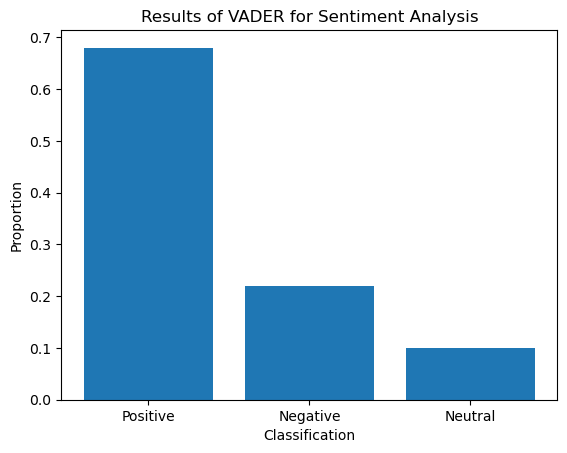

In [40]:
plot_results(vader_results, 'VADER')

Below is the results for our TextBlob model. It returned 42% of the articles as positive, 34% as negative, and 24% as neutral. 

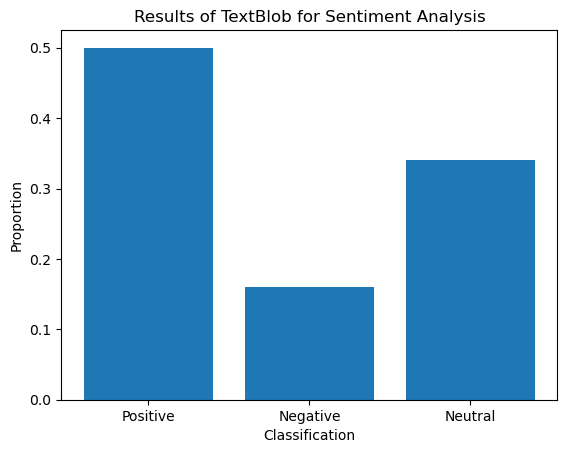

In [42]:
plot_results(textblob_results, 'TextBlob')

Part 4

Here, we will make the Advanced Sentiment Analysis using BERT (Transformers). To accomplish this, we use the BERT base model that is uncased. We then utilzie the BERT specific tokenization to classify each tweet using this pretrained model. 

C:\Users\jack.hernon\AppData\Local\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


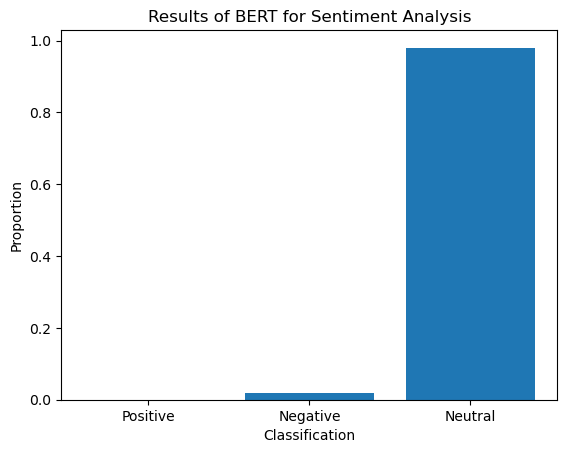

In [56]:
# Import the necessary libraries from HuggingFace and PyTorch
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the pre-trained BERT tokenizer and model for sequence classification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # 3 labels for positive, negative, neutral

# Function to preprocess and take a certain tweet and determine classification
def classify_tweet_BERT(tweet):
    # Tokenize the input tweet and create a tensor
    inputs = tokenizer(tweet, return_tensors="pt", max_length=128, truncation=True, padding='max_length')
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract logits from the outputs
    logits = outputs.logits

    # Get the predicted sentiment (0: Negative, 1: Neutral, 2: Positive)
    predicted_label = torch.argmax(logits, dim=1).item()

    # Map the predicted label to a human-readable sentiment
    sentiment = ["Negative", "Neutral", "Positive"][predicted_label]
    return sentiment

def classify_BERT(list_of_lists): 
    num_samples = len(list_of_lists)
    ret_list = []
    for ls in list_of_lists: 
        sent = classify_tweet_BERT(ls)
        ret_list.append(sent)
    return {'Positive': len([val for val in ret_list if val == 'Positive']) / num_samples, 'Negative': len([val for val in ret_list if val == 'Negative']) / num_samples, 'Neutral': len([val for val in ret_list if val == 'Neutral']) / num_samples}

BERT_results = classify_BERT(preprocess_arts)

plot_results(BERT_results, 'BERT')

Now that we can classify tweets using BERT, we will compare the results of textblob, and VADER to BERT using the below function:

In [54]:
# Function to compare results from all models
def compare_sentiments(tweet):
    print(f"\nTweet/Event: {tweet}")
    
    # BERT sentiment
    bert_sentiment = classify_tweet_BERT(tweet)
    print(f"BERT Sentiment: {bert_sentiment}")
    
    # TextBlob sentiment analisis
    textblob_sentiment = classify_with_textblob(tweet)
    print(f"TextBlob Sentiment: {textblob_sentiment}")
    
    # VADER sentiment analysis
    vader_sentiment = classify_with_vader(tweet)
    print(f"VADER Sentiment: {vader_sentiment}")

# Processed summaries as sentences for sentiment analysis
# Run sentiment analysisevent summaries for all sentences
for sentence in preprocess_arts:
    compare_sentiments(sentence)



Tweet/Event: SUV Volkswagen Scouting Electric vehicle Pickup truck vehicle International Harvester Scout chief executive officer International Harvester Rivian South Carolina Ford Bronco Volkswagen Group United States Navistar drive Truck Rivian r1 T Electric car Minnesota Jeep Wrangler Ute vehicle Ford Motor Company Donald Trump Germany Compass Jeep Columbia South Carolina
BERT Sentiment: Neutral
TextBlob Sentiment: Neutral
VADER Sentiment: Positive

Tweet/Event: Donald Trump Kamala Harris CNN Jen Dillon Joe Biden Democratic Party United States Vice President United States Republican Party United States 2016 United States presidential debate 2016 United States presidential election American Broadcasting Company Wilmington North Carolina Truth Social North Carolina United States Donald Trump 2016 presidential campaign Philadelphia early vote ABC News Atlanta Georgia Twitter Swing state social medium 2020 United States presidential debate Tim Walz Election Day United States White House

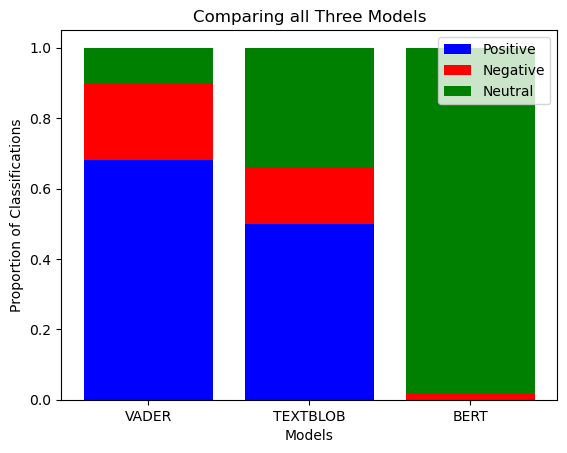

In [70]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


# Function to plot the comparison of the three models
def plot_model_comparisons():

    # Get all models    
    models = ['VADER', 'TEXTBLOB', 'BERT']

    # Compile proprtions into dictionaries 
    weights = {
    'Positive': np.array([vader_results['Positive'], textblob_results['Positive'], BERT_results['Positive']]), 
    'Negative': np.array([vader_results['Negative'], textblob_results['Negative'], BERT_results['Negative']]), 
    'Neutral': np.array([vader_results['Neutral'], textblob_results['Neutral'], BERT_results['Neutral']])
    }
    

    # Create stacked bars for each model
    plt.bar(models, weights['Positive'], color = 'b')
    plt.bar(models, weights['Negative'], bottom = weights['Positive'], color = 'r')
    plt.bar(models, weights['Neutral'], bottom = weights['Positive'] + weights['Negative'], color = 'g')

    # add labels, a legend, and a titleS
    plt.xlabel('Models')
    plt.ylabel('Proportion of Classifications')
    plt.legend(['Positive', 'Negative', 'Neutral'])
    plt.title('Comparing all Three Models')    
    plt.show()
# Plot the results
plot_model_comparisons()


It is very evident that the TextBlob, VADER, and BERT models returned different sentiments. The VADER and Textblob models appeared to perform similarly, while the BERT model performed very differently. This could be due to the lack of fine tuning on the BERT model. In this scenario, finetuning is impossible because we do not have any labeled data specific to our dataset; this made it impossible to split the data into the testing and training segments. Additionally, it is possible BERT works better in more raw data that is not preprocessed in our way. Transforming the sentances into an incoherent collection of words could have diminished the BERT model's abiltiy to accurately classify the reviews. 